In [1]:
!pip install git+https://github.com/gonzalezm/NNhealpix.git

  Cloning https://github.com/gonzalezm/NNhealpix.git to /tmp/pip-req-build-ockqqgao
  Running command git clone -q https://github.com/gonzalezm/NNhealpix.git /tmp/pip-req-build-ockqqgao
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-hwc0t1wl/wheels/01/64/0c/e09ec3f7352cf0b6494c569f85c43fe93ed1e56b49db38a3d7
Successfully built nnhealpix


In [2]:
!pip install camb
!pip install healpy

In [3]:
import keras as kr
import datetime
import nnhealpix.layers
from google.colab import drive
drive.mount('/content/gdrive')

today = datetime.datetime.now().strftime('%Y%m%d_%H_%M_%S')
in_dir="/content/gdrive/My Drive/Colab Notebooks/test17"

model = kr.models.load_model(in_dir +  "_mymodel_CNN.h5py.File", 
                   custom_objects={'OrderMap': nnhealpix.layers.OrderMap})

Using TensorFlow backend.
W0723 11:49:03.137925 139656545941376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


W0723 11:49:03.361499 139656545941376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/nnhealpix/layers/__init__.py:35: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0723 11:49:03.379963 139656545941376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 11:49:03.411648 139656545941376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0723 11:49:03.535287 139656545941376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W07

In [4]:
import camb
from camb import initialpower
import healpy as hp 
import numpy as np
from pylab import *
rcParams['image.cmap'] = 'jet'

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
#calculate results for these parameters
results = camb.get_results(pars)
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)


#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print(totCL.shape)

ls = np.arange(totCL.shape[0])

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential
(2551, 4)


In [5]:
print(ls[0])
CL = totCL[:,0]/ls/(ls+1)
CL[0]=0

ns = 16
lmax = 2*ns-1
nl = 2*ns
nalm = (nl)*(nl+1)/2

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [0]:
### Target power spectra

nbmodels = 110000
nnn = int(nbmodels/30)
npixok = 12*ns**2
limit_shape = 3*ns
okpix = np.arange(npixok)
mymaps = np.zeros((nbmodels, npixok))
myalms = np.zeros((nbmodels, int(nalm)), dtype=complex128)
expcls = np.zeros((nbmodels, nl))
mycls = np.zeros((nbmodels, nl))
allshapes = np.zeros((nbmodels, len(ls)))
for i in range(nbmodels):
  ylo = np.random.rand()*2
  yhi = np.random.rand()*2
  theshape = ylo+(yhi-ylo)/(limit_shape)*ls
  theshape[theshape < 0] = 0
  theshape[limit_shape:] = 0
  allshapes[i,:] = theshape
  theCL = CL*theshape
  themap = hp.synfast(theCL, ns, pixwin=False, verbose=False)
  mymaps[i,:] = themap[okpix]
  expcls[i,:], myalms[i,:] = hp.anafast(themap, lmax=lmax, alm=True)
  mycls[i,:] = theCL[0:nl]

In [7]:
# Training
nbtest = 10000

mapx = (mymaps-np.mean(mymaps))/np.std(mymaps)
clstd = np.std(mycls)
clmean = np.mean(mycls)
cly = (mycls-np.mean(mycls))/np.std(mycls)

mapx = mapx.reshape(mapx.shape[0], len(mapx[0]), 1)

mymaps = mymaps.reshape(mymaps.shape[0], len(mymaps[0]), 1)

class PrintNum(kr.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if (epoch) % 10 == 0: 
      print(epoch+1)
    sys.stdout.write('.')
    sys.stdout.flush()

stop = kr.callbacks.EarlyStopping(monitor='val_loss',
                                  verbose = 0,
                                  restore_best_weights=True,
                                  patience=20)

callbacks = [PrintNum(), stop]

history = model.fit(mapx[:(nbmodels-nbtest),:,:], mycls[:(nbmodels-nbtest),:], epochs=10, batch_size=32, validation_split = 0.1, verbose = 0, callbacks=callbacks, shuffle = True)

1
..........

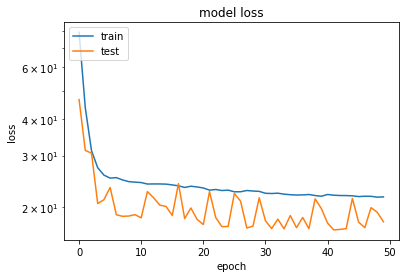

21.683635472954645 16.771649713134767 50


In [8]:
loss1 = np.load(in_dir + '_hist_loss.npy')
val_loss1 = np.load(in_dir + '_hist_val_loss.npy')

loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

loss = np.concatenate((loss1,loss2))
val_loss = np.concatenate((val_loss1,val_loss2))

plot(loss)
plot(val_loss)
title('model loss')
ylabel('loss')
xlabel('epoch')
legend(['train', 'test'], loc='upper left')
yscale('log')
show()
print(min(loss), min(val_loss), len(val_loss))

In [0]:
mymaps_test = mapx[(nbmodels-nbtest):,:,:]
mycls_test = mycls[(nbmodels-nbtest):,:]
expcls_test = expcls[(nbmodels-nbtest):,:]

result = model.predict(mymaps_test, batch_size=128)


In [10]:
mean_err = np.mean(abs((result[:,2:]-mycls_test[:,2:])/mycls_test[:,2:]*100))
mean_err_ana = np.mean(abs((expcls_test[:,2:]-mycls_test[:,2:])/mycls_test[:,2:]*100))
print(mean_err)
print(mean_err_ana)

23.889915106695522
22.312330086797022


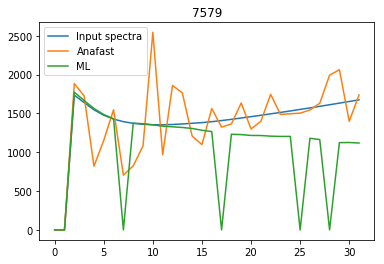

In [11]:
lt=np.arange(nl)
num=np.random.randint(result.shape[0])
plot(lt, lt*(lt+1)*mycls_test[num,:],label ='Input spectra')
plot(lt, lt*(lt+1)*expcls_test[num,:],label ='Anafast')
plot(lt, lt*(lt+1)*result[num,:],label ='ML')
title(num)
legend()

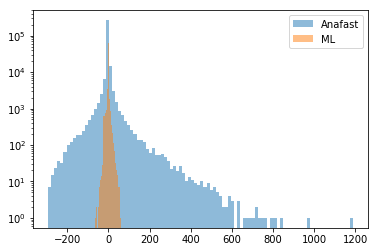

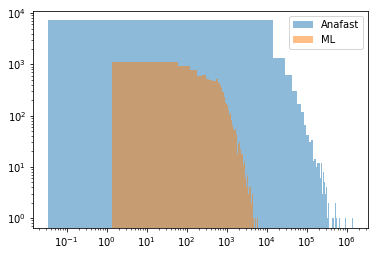

In [14]:
figure()
a=hist(np.ravel(expcls_test[:,2:]-mycls_test[:,2:]), bins=100, alpha=0.5, label='Anafast')
a=hist(np.ravel(result[:,2:]-mycls_test[:,2:]), bins=100, alpha=0.5, label = 'ML')
yscale('log')
legend()

ch2anafast = np.sum((expcls_test[:,2:]-mycls_test[:,2:])**2, axis=1)
ch2ML = np.sum((result[:,2:]-mycls_test[:,2:])**2, axis=1)

figure()
a=hist(ch2anafast, bins=100, alpha=0.5, label='Anafast')
a=hist(ch2ML, bins=100, alpha=0.5, label = 'ML')
yscale('log')
legend()

In [13]:
import keras as kr
import datetime
from google.colab import drive
drive.mount('/content/gdrive')

today = datetime.datetime.now().strftime('%Y%m%d_%H_%M_%S')
out_dir="/content/gdrive/My Drive/Colab Notebooks/"

kr.models.save_model(model, out_dir +  "test18" + "_mymodel_CNN.h5py.File")
np.save(out_dir + "test18" + '_hist_loss', loss)
np.save(out_dir + "test18" + '_hist_val_loss', val_loss)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
